In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
from itertools import product
from sklearn.mixture import GaussianMixture


import sys

from sklearn import preprocessing

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.ensemble import AdaBoostClassifier
#from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
from catboost import CatBoostClassifier
#import category_encoders as ce
#from mlxtend.classifier import StackingCVClassifier

from sklearn.metrics import classification_report,accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif, chi2



# Household Observable Characteristics and Poverty Level in Costa Rica


#### Ronald Bustamante Medina
CIMPA - Escuela de Matemática, UCR

 ![Kaggle](kaggle.jpg)

https://www.kaggle.com/c/costa-rican-household-poverty-prediction

### Banko Interamericano de Desarrollo

- Las ayudas se asignan a hogares con cierto nivel de pobreza

- El nivel de pobreza se determina con un test de medios (means test) que depende de los ingresos.

- Se utiliza un Proxy Means Test (PMT): 
algoritmo que intenta determinar el nivel de pobreza a partir de características observables del hogar.

### ¿Será posible tener resultados más consistentes utilizando modelos de clasificación automática?

### Datos

- Personal (edad, género, educación, etc.)

- De los miembros del hogar (número, menores, género, educación, etc.)

- De la vivienda (condiciones, construcción, facilidades, renta, etc.)

- Poseciones (número de celulares, pantallas, etc.)

### Classes

1. Pobreza extrema
2. Pobreza moderada
3. Hogar vulnerable
4. Hogar no vulnerable

In [2]:
train = pd.read_csv('./train_f.csv')

In [3]:
train.drop(['Unnamed: 0'], axis=1, inplace=True)

In [4]:
train.head()

,Id,rent,hacdor,rooms,hacapo,bath_in,refrig,tablet,num_tablets,r4h1,...,age_mean,age_std,age_min,age_max,age_sum,escolari_age_mean,escolari_age_std,escolari_age_min,escolari_age_max,escolari_age_sum
0,ID_279628684,190000.0,0,3,0,1,1,0,0.0,0,...,43.0,0.000000,43,43,43,0.232558,0.000000,0.232558,0.232558,0.232558
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,67.0,0.000000,67,67,67,0.179104,0.000000,0.179104,0.179104,0.179104
2,ID_68de51c94,0.0,0,8,0,1,1,0,0.0,0,...,92.0,0.000000,92,92,92,0.119565,0.000000,0.119565,0.119565,0.119565
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,25.0,14.899664,8,38,100,0.341544,0.126943,0.249997,0.529409,1.366175
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,25.0,14.899664,8,38,100,0.341544,0.126943,0.249997,0.529409,1.366175


### Distribución de las clases

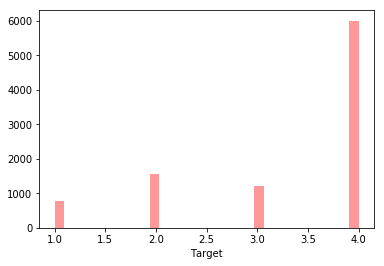

In [5]:
sns.distplot(train['Target'], kde=False, color="r")


#### No balanceada

### Resampleo

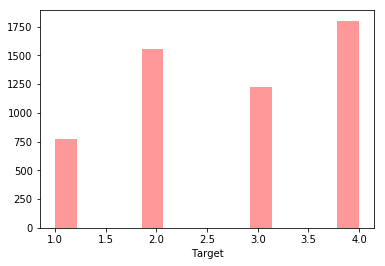

In [6]:
train_2=train.drop(train.query('Target == 4').sample(frac=.7).index)
sns.distplot(train_2['Target'], kde=False, color="r")

### A tomar en cuenta

- En el conjunto hay datos de diferentes personas que perteneces al mismo hogar.
- La inferencia se hace con base en los datos de una persona.

### Evaluación

Precisión: 
$$\cfrac{VP}{VP+FP}$$

Exhaustividad:
$$\cfrac{VP}{VP+FN}$$

Puntaje F1:

$$\cfrac{2}{pr^{-1}+ex^{-1}}$$

Macro: promedio de los puntajes

Micro: promedio de los puntajes tomando en cuenta la frecuencia de cada clase.

In [7]:
idh_array=train_2['idhogar'].unique()
train_hid, valid_hid = train_test_split(idh_array,test_size = 0.2,
                                                      random_state=42)                                                                                                     

In [8]:
train_sp=train_2[train_2['idhogar'].isin(train_hid)]
valid_sp=train_2[train_2['idhogar'].isin(valid_hid)]

### Con las 4 clases

In [9]:
X_train=train_sp.drop(['Target','Id', 'idhogar'] , axis =1)
Y_train=train_sp.Target
X_train.shape

(4269, 114)

In [10]:
gm = GaussianMixture(n_components=4)
gm.fit(X_train)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=4, n_init=1, precisions_init=None,
                random_state=None, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [11]:
X_train['Gaussian_Mixture'] = gm.predict(X_train)


In [12]:
X_valid=valid_sp.drop(['Target','Id', 'idhogar'] , axis =1)
Y_valid=valid_sp.Target
X_valid.shape

(1085, 114)

In [13]:
X_valid['Gaussian_Mixture'] = gm.predict(X_valid)


### Selección de características

In [14]:
fs = SelectKBest(score_func=f_classif, k=60)


ANOVA valor F.

In [15]:
feature_sel = fs.fit(X_train, Y_train)
selected_columns_1=X_train.columns[feature_sel.get_support()]
selected_columns_1

Index(['rent', 'hacdor', 'rooms', 'tablet', 'num_tablets', 'r4h1', 'r4m1',
       'r4m3', 'r4t1', 'r4t3', 'tamviv', 'escolari', 'hhsize', 'cielorazo',
       'hogar_nin', 'hogar_adul', 'hogar_total', 'dependency', 'edjefe',
       'meaneduc', 'bedrooms', 'overcrowding', 'computer', 'television',
       'qmobilephone', 'SQBescolari', 'SQBhogar_total', 'SQBedjefe',
       'SQBhogar_nin', 'SQBovercrowding', 'SQBmeaned', 'epared', 'etecho',
       'piso', 'cocina', 'region', 'educacion', 'episo', 'pared',
       'child_ratio', 'male_adult_man_ratio', 'human_density',
       'human_bed_density', 'rent_per_person', 'rent_per_room',
       'mobile_per_person', 'tablet_per_person', 'mobile_per_adult',
       'tablet_per_adult', 'overcr_rm+', 'num_elec', 'escolari_age',
       'escolari_mean', 'escolari_min', 'escolari_max', 'escolari_sum',
       'age_mean', 'escolari_age_mean', 'escolari_age_min',
       'Gaussian_Mixture'],
      dtype='object')

In [16]:
X_train[selected_columns_1].head()

,rent,hacdor,rooms,tablet,num_tablets,r4h1,r4m1,r4m3,r4t1,r4t3,...,num_elec,escolari_age,escolari_mean,escolari_min,escolari_max,escolari_sum,age_mean,escolari_age_mean,escolari_age_min,Gaussian_Mixture
3,180000.0,0,5,1,1.0,0,1,2,1,4,...,1,0.529409,8.25,2,11,33,25.0,0.341544,0.249997,0
5,180000.0,0,5,1,1.0,0,1,2,1,4,...,1,0.289473,8.25,2,11,33,25.0,0.341544,0.249997,2
8,130000.0,1,2,0,0.0,0,2,3,2,4,...,1,0.299999,5.75,0,11,23,19.0,0.241395,0.000000,0
15,90000.0,1,2,0,0.0,0,0,2,0,4,...,1,0.578944,8.50,2,11,34,39.5,0.346615,0.028571,0
17,90000.0,1,2,0,0.0,0,0,2,0,4,...,1,0.578944,8.50,2,11,34,39.5,0.346615,0.028571,0


### Regresión Logística

In [17]:
LR = LogisticRegression(solver='liblinear',random_state=42, max_iter=3000, multi_class='auto')
LR_model_1=LR.fit(X_train[selected_columns_1],Y_train)

#### En el conjunto de validación

In [18]:
preds_lr_1=LR_model_1.predict(X_valid[selected_columns_1])
print(classification_report(Y_valid, preds_lr_1))

              precision    recall  f1-score   support

           1       0.54      0.09      0.15       159
           2       0.41      0.59      0.48       327
           3       0.30      0.10      0.15       221
           4       0.58      0.79      0.67       378

    accuracy                           0.48      1085
   macro avg       0.46      0.39      0.36      1085
weighted avg       0.47      0.48      0.43      1085



### Boosted Trees

#### XGBoost

In [19]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=250, max_depth=7,
                        min_child_weight=3, gamma=0.05, subsample=0.6, colsample_bytree=1.0,
                        objective='multiclass:softmax', nthread=4, scale_pos_weight=1, seed=42)

xgb_model_1=xgb.fit(X_train[selected_columns_1],Y_train)

#### En el conjunto de validación:

In [20]:
preds_xgb_1=xgb_model_1.predict(X_valid[selected_columns_1])
print(classification_report(Y_valid, preds_xgb_1))

              precision    recall  f1-score   support

           1       0.47      0.23      0.31       159
           2       0.43      0.43      0.43       327
           3       0.32      0.19      0.23       221
           4       0.54      0.80      0.65       378

    accuracy                           0.48      1085
   macro avg       0.44      0.41      0.41      1085
weighted avg       0.45      0.48      0.45      1085



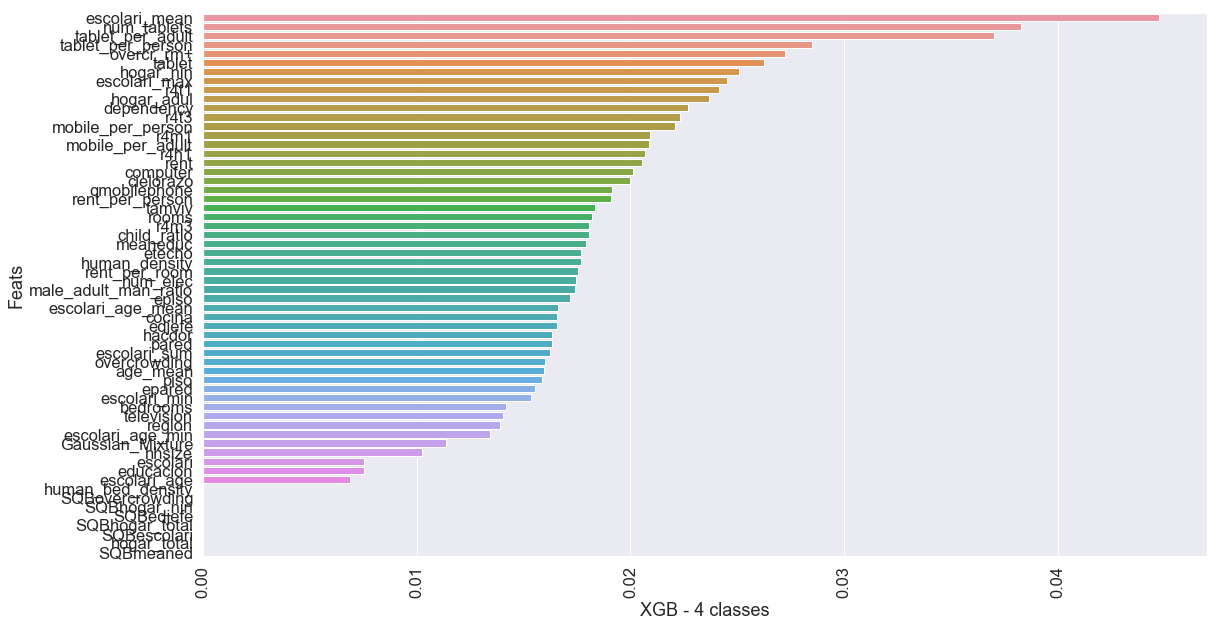

In [21]:
sns.set(font_scale=1.5)

importances_xgb_1 = pd.DataFrame({'Feats': selected_columns_1, 
                             'XGB - 4 classes': xgb_model_1.feature_importances_})
    
importances_xgb_1.sort_values(by=['XGB - 4 classes'], axis='index', ascending=False, inplace=True)

fig = plt.figure(figsize=(18,10))
sns.barplot(x='XGB - 4 classes', y='Feats', data=importances_xgb_1)
plt.xticks(rotation='vertical')
plt.show()

#### LightGBM

In [22]:
lgbm = lgb.LGBMClassifier(max_depth=9, learning_rate=0.01, objective='multiclass',
                             random_state=None, silent=True, metric='None', 
                             n_jobs=4, n_estimators=2500, class_weight='balanced',
                             colsample_bytree =  0.93, min_child_samples = 20, num_leaves = 21, subsample = 0.96)

lgb_model_1=lgbm.fit(X_train[selected_columns_1],Y_train)

#### En el conjunto de validación:

In [23]:
preds_lgb_1=lgb_model_1.predict(X_valid[selected_columns_1])
print(classification_report(Y_valid, preds_lgb_1))

              precision    recall  f1-score   support

           1       0.30      0.22      0.25       159
           2       0.38      0.28      0.32       327
           3       0.29      0.22      0.25       221
           4       0.52      0.77      0.62       378

    accuracy                           0.43      1085
   macro avg       0.37      0.37      0.36      1085
weighted avg       0.40      0.43      0.40      1085



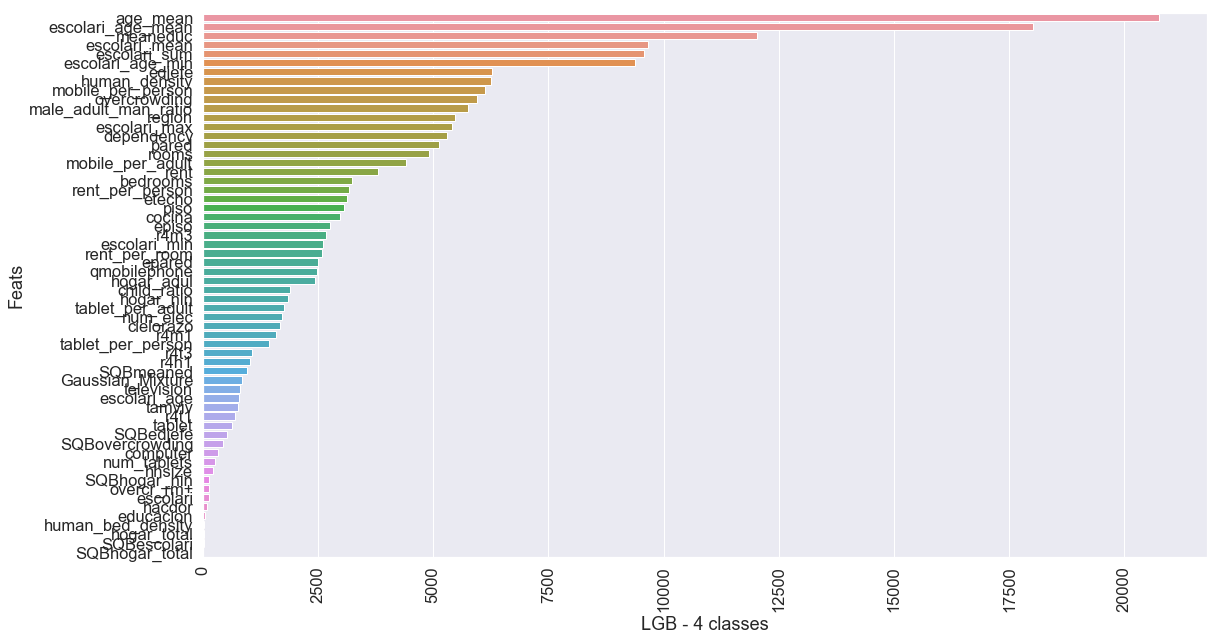

In [24]:
sns.set(font_scale=1.5)
importances_lgb_1 = pd.DataFrame({'Feats': selected_columns_1, 
                             'LGB - 4 classes': lgb_model_1.feature_importances_})

    
importances_lgb_1.sort_values(by=['LGB - 4 classes'], axis='index', ascending=False, inplace=True)

fig = plt.figure(figsize=(18,10))
sns.barplot(x='LGB - 4 classes', y='Feats', data=importances_lgb_1)
plt.xticks(rotation='vertical')
plt.show()

### Bosques aleatorios

In [25]:
rf = RandomForestClassifier(n_estimators=100, 
                            criterion='gini',
                            max_depth=30,
                            max_features='auto',
                            random_state=42)

rf_model_1=rf.fit(X_train[selected_columns_1],Y_train)

#### En el conjunto de validación:

In [26]:
preds_rf_1=rf_model_1.predict(X_valid[selected_columns_1])
print(classification_report(Y_valid, preds_rf_1))

              precision    recall  f1-score   support

           1       0.46      0.23      0.31       159
           2       0.41      0.42      0.42       327
           3       0.34      0.18      0.24       221
           4       0.55      0.81      0.65       378

    accuracy                           0.48      1085
   macro avg       0.44      0.41      0.40      1085
weighted avg       0.45      0.48      0.45      1085



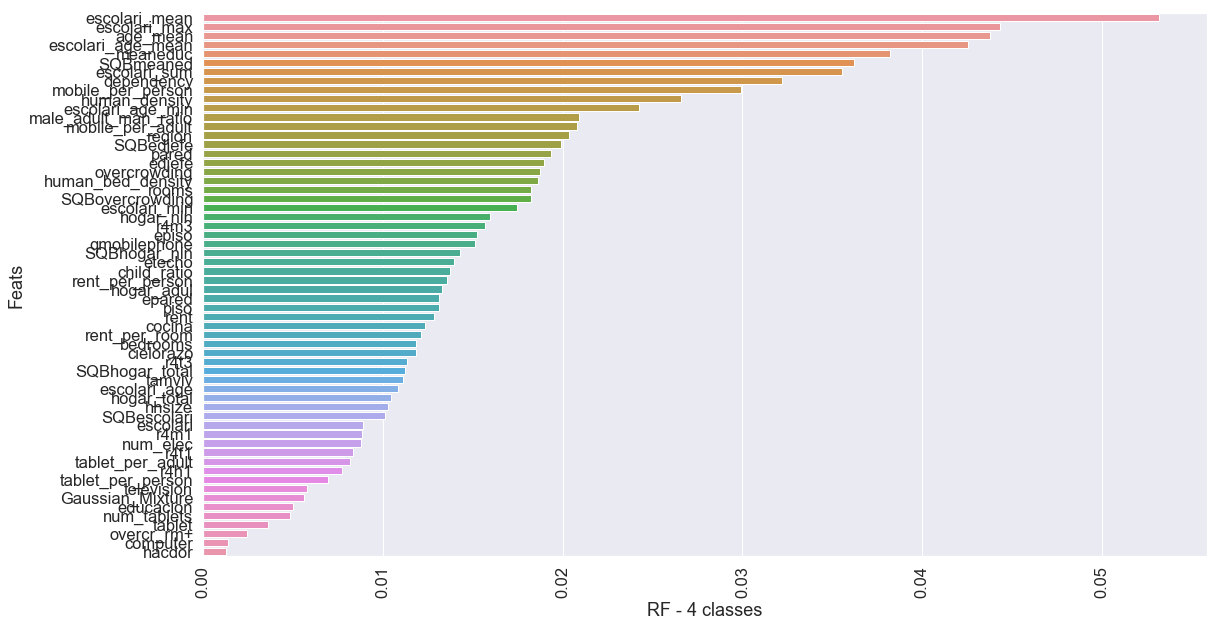

In [27]:
sns.set(font_scale=1.5)
importances_rf_1 = pd.DataFrame({'Feats': selected_columns_1, 
                             'RF - 4 classes': rf_model_1.feature_importances_})

    
importances_rf_1.sort_values(by=['RF - 4 classes'], axis='index', ascending=False, inplace=True)

fig = plt.figure(figsize=(18,10))
sns.barplot(x='RF - 4 classes', y='Feats', data=importances_rf_1)
plt.xticks(rotation='vertical')
plt.show()

### Dos clases

1: Extrema pobreza

0: El resto

In [28]:
newtarget=(train_2.Target!=1).astype(int)

In [29]:
train_3=train_2.copy()

In [30]:
train_3['Target']=newtarget

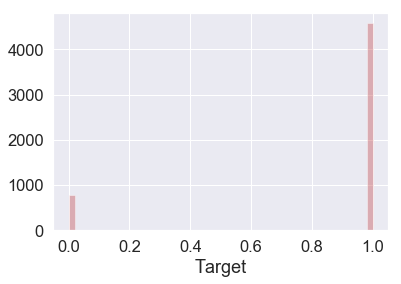

In [31]:
sns.distplot(train_3['Target'], kde=False, color="r")

In [32]:
train_sp3=train_3[train_2['idhogar'].isin(train_hid)]
valid_sp3=train_3[train_2['idhogar'].isin(valid_hid)]
X_train=train_sp3.drop(['Target','Id', 'idhogar'] , axis =1)
Y_train=train_sp3.Target
print(X_train.shape)
X_valid=valid_sp3.drop(['Target','Id', 'idhogar'] , axis =1)
Y_valid=valid_sp3.Target
print(X_valid.shape)

(4269, 114)
(1085, 114)


In [33]:
gm = GaussianMixture(n_components=4)
gm.fit(X_train)

X_train['Gaussian_Mixture'] = gm.predict(X_train)
X_valid['Gaussian_Mixture'] = gm.predict(X_valid)
print(X_train.shape)
print(X_valid.shape)

(4269, 115)
(1085, 115)


### Selección de características

In [34]:
feature_sel = fs.fit(X_train, Y_train)
selected_columns_2=X_train.columns[feature_sel.get_support()]
selected_columns_2

Index(['rent', 'hacdor', 'rooms', 'refrig', 'tablet', 'r4h1', 'r4h2', 'r4m1',
       'r4m3', 'r4t1', 'r4t2', 'escolari', 'cielorazo', 'hogar_nin',
       'hogar_adul', 'dependency', 'edjefe', 'edjefa', 'meaneduc', 'bedrooms',
       'overcrowding', 'computer', 'television', 'qmobilephone', 'age',
       'SQBescolari', 'SQBhogar_total', 'SQBedjefe', 'SQBhogar_nin',
       'SQBovercrowding', 'SQBmeaned', 'epared', 'etecho', 'piso', 'cocina',
       'educacion', 'episo', 'pared', 'child_ratio', 'male_adult_man_ratio',
       'human_density', 'human_bed_density', 'rent_per_person',
       'rent_per_room', 'mobile_per_person', 'tablet_per_person', 'overcr_rm+',
       'num_elec', 'escolari_age', 'escolari_mean', 'escolari_min',
       'escolari_max', 'escolari_sum', 'age_mean', 'age_min', 'age_max',
       'age_sum', 'escolari_age_mean', 'escolari_age_min', 'escolari_age_max'],
      dtype='object')

### Regresión Logística

In [35]:
LR = LogisticRegression(solver='liblinear',random_state=42, max_iter=3000, multi_class='auto')

LR_model_2=LR.fit(X_train[selected_columns_2],Y_train)

#### En el conjunto de validación

In [36]:
preds_lr_2=LR_model_2.predict(X_valid[selected_columns_2])
print(classification_report(Y_valid, preds_lr_2))

              precision    recall  f1-score   support

           0       0.72      0.08      0.15       159
           1       0.86      0.99      0.92       926

    accuracy                           0.86      1085
   macro avg       0.79      0.54      0.54      1085
weighted avg       0.84      0.86      0.81      1085



#### Boosted Trees

#### XGBoost

In [37]:
xgb = XGBClassifier(learning_rate=0.1, n_estimators=250, max_depth=7,
                        min_child_weight=3, gamma=0.05, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=42)

xgb_model_2=xgb.fit(X_train[selected_columns_2],Y_train)

#### En el conjunto de validación

In [38]:
preds_xgb_2=xgb_model_2.predict(X_valid[selected_columns_2])
print(classification_report(Y_valid, preds_xgb_2))

              precision    recall  f1-score   support

           0       0.51      0.17      0.25       159
           1       0.87      0.97      0.92       926

    accuracy                           0.85      1085
   macro avg       0.69      0.57      0.59      1085
weighted avg       0.82      0.85      0.82      1085



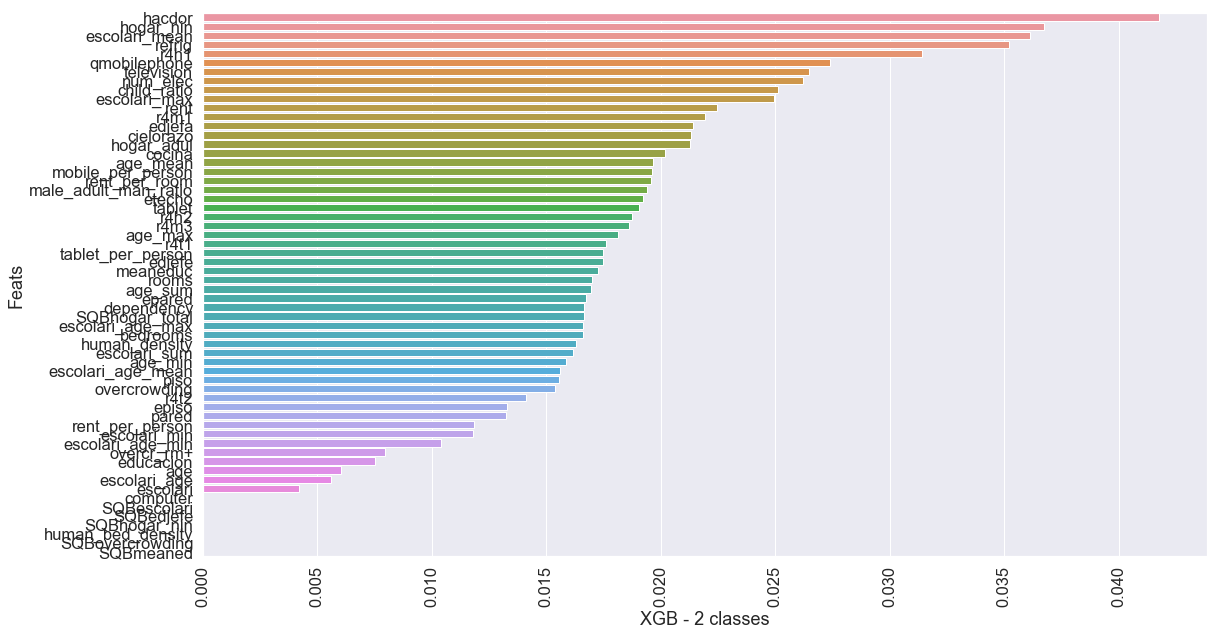

In [39]:
sns.set(font_scale=1.5)
importances_xgb_2 = pd.DataFrame({'Feats': selected_columns_2, 
                             'XGB - 2 classes': xgb_model_2.feature_importances_})

    
importances_xgb_2.sort_values(by=['XGB - 2 classes'], axis='index', ascending=False, inplace=True)

fig = plt.figure(figsize=(18,10))
sns.barplot(x='XGB - 2 classes', y='Feats', data=importances_xgb_2)
plt.xticks(rotation='vertical')
plt.show()

#### LightGBM

In [40]:
lgbm= lgb.LGBMClassifier(max_depth=9, learning_rate=0.01, objective='binary',
                             random_state=None, silent=True, metric='None', 
                             n_jobs=4, n_estimators=2500, class_weight='balanced',
                             colsample_bytree =  0.93, min_child_samples = 20, num_leaves = 21, subsample = 0.96)

lgb_model_2=lgbm.fit(X_train[selected_columns_2],Y_train)

#### En el conjunto de validación

In [41]:
preds_lgb_2=lgb_model_2.predict(X_valid[selected_columns_2])
print(classification_report(Y_valid, preds_lgb_2))

              precision    recall  f1-score   support

           0       0.39      0.16      0.22       159
           1       0.87      0.96      0.91       926

    accuracy                           0.84      1085
   macro avg       0.63      0.56      0.57      1085
weighted avg       0.80      0.84      0.81      1085



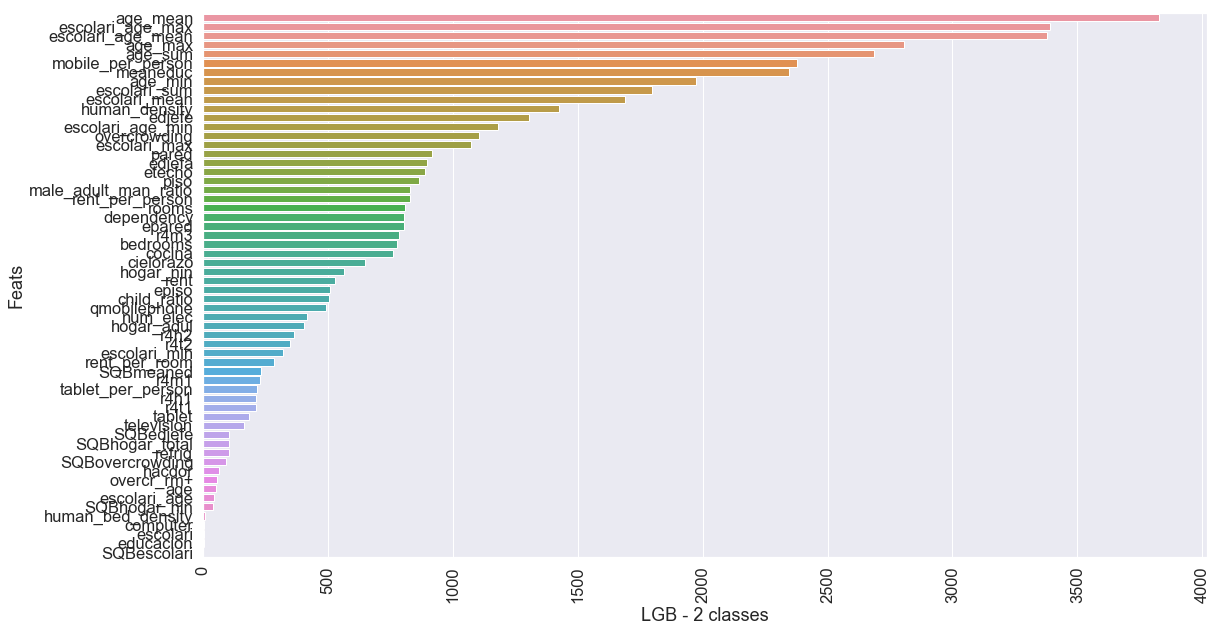

In [42]:
sns.set(font_scale=1.5)
importances_lgb_2 = pd.DataFrame({'Feats': selected_columns_2, 
                             'LGB - 2 classes': lgb_model_2.feature_importances_})

    
importances_lgb_2.sort_values(by=['LGB - 2 classes'], axis='index', ascending=False, inplace=True)

fig = plt.figure(figsize=(18,10))
sns.barplot(x='LGB - 2 classes', y='Feats', data=importances_lgb_2)
plt.xticks(rotation='vertical')
plt.show()

### Bosques aleatorios

In [43]:
rf = RandomForestClassifier(n_estimators=10, 
                            criterion='gini',
                            max_depth=20,
                            max_features='auto',
                            random_state=42)

rf_model_2=rf.fit(X_train[selected_columns_2],Y_train)

#### En el conjunto de validación

In [44]:
preds_rf_2=rf_model_2.predict(X_valid[selected_columns_2])
print(classification_report(Y_valid, preds_rf_2))

              precision    recall  f1-score   support

           0       0.56      0.29      0.38       159
           1       0.89      0.96      0.92       926

    accuracy                           0.86      1085
   macro avg       0.72      0.63      0.65      1085
weighted avg       0.84      0.86      0.84      1085



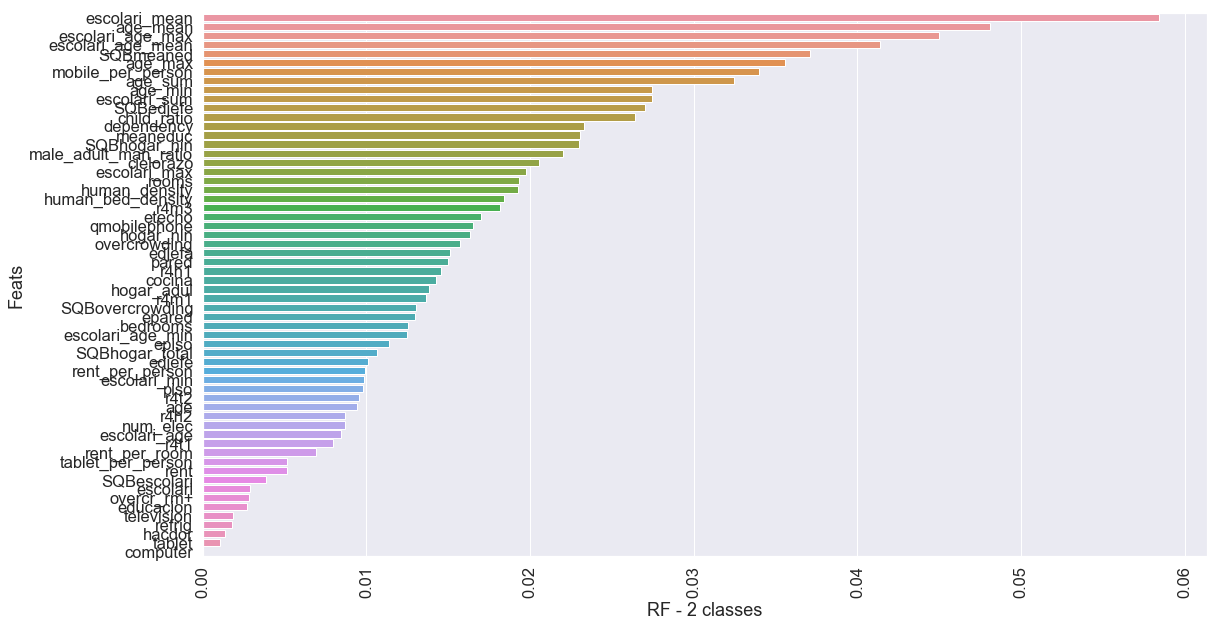

In [45]:
sns.set(font_scale=1.5)
importances_rf_2 = pd.DataFrame({'Feats': selected_columns_2, 
                             'RF - 2 classes': rf_model_2.feature_importances_})

    
importances_rf_2.sort_values(by=['RF - 2 classes'], axis='index', ascending=False, inplace=True)

fig = plt.figure(figsize=(18,10))
sns.barplot(x='RF - 2 classes', y='Feats', data=importances_rf_2)
plt.xticks(rotation='vertical')
plt.show()

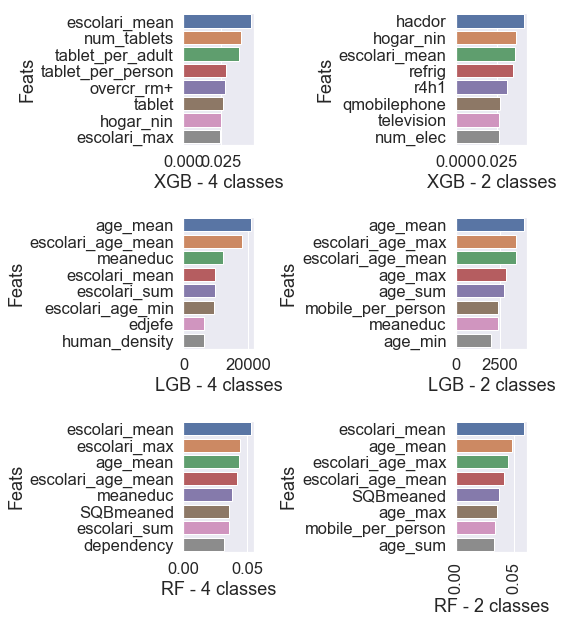

In [46]:
nr_rows = 3
nr_cols = 2

#cols_review = ['h', 'v', 'l']

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4,nr_rows*3), squeeze=False)

sns.barplot(x='XGB - 4 classes', y='Feats', data=importances_xgb_1.head(8),ax = axs[0][0])
plt.xticks(rotation='vertical')

sns.barplot(x='XGB - 2 classes', y='Feats', data=importances_xgb_2.head(8),ax = axs[0][1])
plt.xticks(rotation='vertical')

sns.barplot(x='LGB - 4 classes', y='Feats', data=importances_lgb_1.head(8),ax = axs[1][0])
plt.xticks(rotation='vertical')

sns.barplot(x='LGB - 2 classes', y='Feats', data=importances_lgb_2.head(8),ax = axs[1][1])
plt.xticks(rotation='vertical')

sns.barplot(x='RF - 4 classes', y='Feats', data=importances_rf_1.head(8),ax = axs[2][0])
plt.xticks(rotation='vertical')

sns.barplot(x='RF - 2 classes', y='Feats', data=importances_rf_2.head(8),ax = axs[2][1])
plt.xticks(rotation='vertical')
 
# for r in range(0,nr_rows):
#     for c in range(0, nr_cols):  
#         col = r*nr_cols+c
#         if col < len(cols_review):
#             x=np.random.rand(5) * 10
#             y=np.random.rand(5)
#             sns.set(style="darkgrid")
#             sns.barplot(x, y, alpha=0.9,ax = axs[r][c])
#             plt.ylabel('Nu', fontsize=12)
#             plt.xlabel(col, fontsize=12)
plt.tight_layout()    
plt.show()

![Importancias](imp.png "Importancias")
